In [3]:
from dataloaders import BaseDataset
from models import *
from utils.embeddings import *
from torch.utils.data import DataLoader

In [63]:
dataset = BaseDataset(model_name="NCNN",
                      img_dir=r'Datasets\Folds\0\Test',
                      soft='None',
                      cache=False)

test_dataloader = DataLoader(
        dataset, 
        batch_size=8, 
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )


model = NCNN()
model.load_state_dict(torch.load(r'experiments\NCNN\20250718_0744_NCNN\Model\best_model.pt'))

<All keys matched successfully>

In [64]:
embeddings = extract_embeddings(model, test_dataloader, device='cuda')

100%|██████████| 7/7 [00:00<00:00, 10.03it/s]


In [65]:
embeddings

{'embeddings': array([[1.5634886 , 0.        , 1.0454044 , 0.        , 0.        ,
         0.29679286, 0.557494  , 0.57160777],
        [2.1205812 , 0.        , 1.500886  , 0.        , 0.        ,
         0.        , 0.03691046, 0.23452568],
        [1.2948147 , 0.        , 0.7723489 , 0.        , 0.        ,
         0.56431687, 0.8284292 , 0.7441171 ],
        [0.8208289 , 0.        , 0.35790238, 0.        , 0.        ,
         0.9891403 , 1.2938446 , 1.0270805 ],
        [2.2955139 , 0.        , 1.6487981 , 0.        , 0.        ,
         0.        , 0.        , 0.17767295],
        [0.17360394, 0.        , 0.        , 0.        , 0.        ,
         1.7870678 , 2.00358   , 1.4376755 ],
        [1.9881212 , 0.        , 1.3806802 , 0.        , 0.        ,
         0.        , 0.14475752, 0.3075884 ],
        [2.3335805 , 0.        , 1.3945082 , 0.        , 0.        ,
         0.        , 0.        , 0.04222494],
        [2.326356  , 0.        , 1.4083486 , 0.        , 0.       

In [66]:
idx, dist, paths = find_nearest(embeddings['embeddings'][0], embeddings, k=5)

In [67]:
idx, dist, paths

(array([ 0, 34, 36, 27,  2], dtype=int64),
 array([0.        , 0.2416168 , 0.30015445, 0.3115717 , 0.56699157],
       dtype=float32),
 array(['Datasets\\Folds\\0\\Test\\ID167_iCOPE_S15_pain.jpg',
        'Datasets\\Folds\\0\\Test\\ID589_UNIFESP_S53_nopain.jpg',
        'Datasets\\Folds\\0\\Test\\ID591_UNIFESP_S53_pain.jpg',
        'Datasets\\Folds\\0\\Test\\ID547_UNIFESP_S49_pain.jpg',
        'Datasets\\Folds\\0\\Test\\ID169_iCOPE_S15_pain.jpg'], dtype=object))

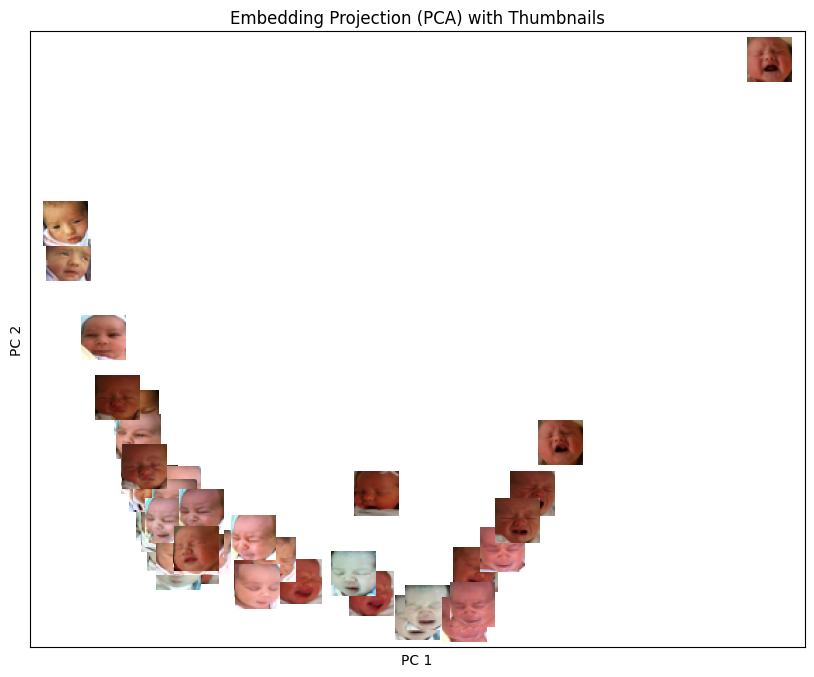

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image

# `store` is the dictionary returned by extract_embeddings
embeddings_aux = embeddings["embeddings"]
paths = embeddings["paths"]

# Reduce to 2-D
coords = PCA(n_components=2, random_state=0).fit_transform(embeddings_aux)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Embedding Projection (PCA) with Thumbnails")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.scatter(coords[:, 0], coords[:, 1], alpha=0.5)

for (x, y), img_path in zip(coords, paths):
    img = Image.open(img_path)
    img = img.resize((32, 32))  # tweak size for thumbnail
    thumb = OffsetImage(img)  # tweak zoom for thumbnail size
    ab = AnnotationBbox(thumb, (x, y), frameon=False)
    ax.add_artist(ab)

# Hide axis ticks for clarity
ax.set_xticks([])
ax.set_yticks([])
plt.show()


Query image: Datasets\Folds\0\Test\ID72_iCOPE_S07_pain.jpg


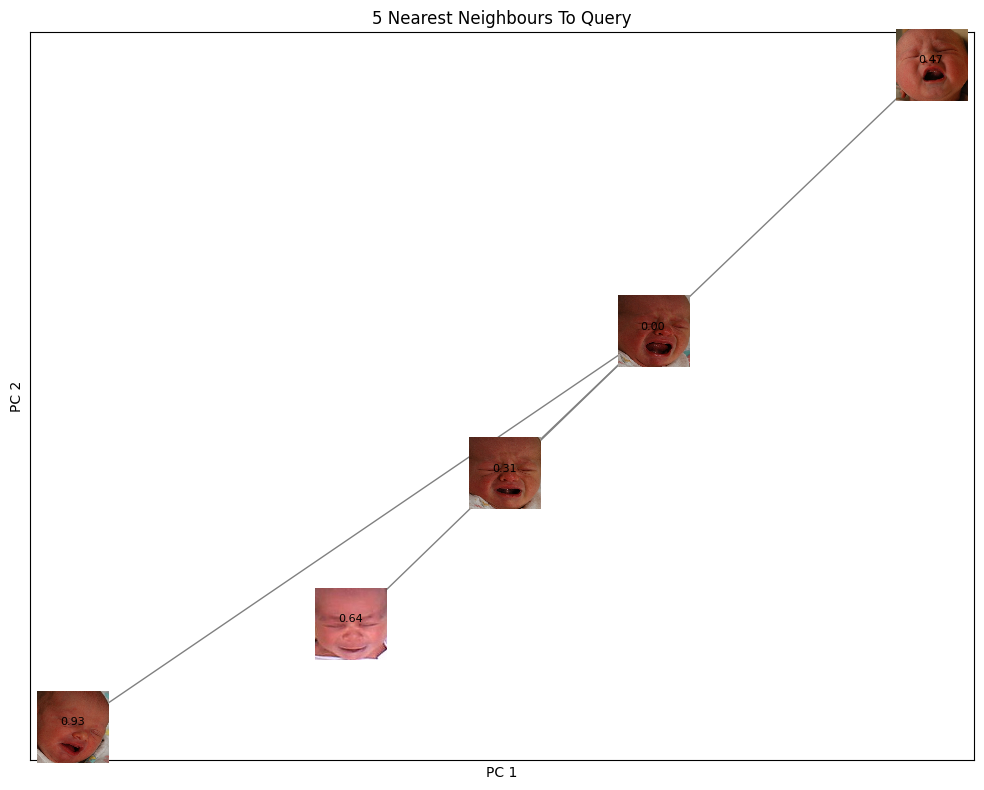

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# --- Inputs you need to set -------------------------------------------------
query_embedding = embeddings["embeddings"][42]  # shape (D,) or (1, D); stash from your lookup
query_path = embeddings["paths"][42]  # string pointing to the query image on disk
k = 5                        # number of nearest neighbours to show

print(f"Query image: {query_path}")
# ---------------------------------------------------------------------------

# Hold the dictionary returned by extract_embeddings
embeddings_aux = embeddings["embeddings"]
paths = embeddings["paths"]

# Reduce to 2-D for visualisation
pca = PCA(n_components=2, random_state=0)
coords = pca.fit_transform(embeddings_aux)
query_pt = pca.transform(np.atleast_2d(query_embedding))[0]

# Find the nearest neighbour indices, distances, and paths
nn_idx, nn_dist, nn_paths = find_nearest(query_embedding, embeddings, k=k)
nn_pts = coords[nn_idx]

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title(f"{k} Nearest Neighbours To Query")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# Helper to add image thumbnails
def add_thumbnail(ax, xy, img_path, zoom=0.15, border=False, border_color="red"):
    img = Image.open(img_path)
    artists = []
    # Base thumbnail
    artists.append(ax.add_artist(AnnotationBbox(
        OffsetImage(img, zoom=zoom), xy, frameon=False
    )))
    # Optional border (query highlight)
    if border:
        artists.append(ax.scatter(*xy, s=4000 * zoom, facecolors="none",
                                  edgecolors=border_color, linewidths=2))
    return artists

# Plot the query image thumbnail
#add_thumbnail(ax, query_pt, query_path, zoom=0.2, border=True)

# Plot neighbour thumbnails and connect with lines
for pt, path, dist in zip(nn_pts, nn_paths, nn_dist):
    ax.plot([query_pt[0], pt[0]], [query_pt[1], pt[1]], color="gray", linewidth=1)
    artists = add_thumbnail(ax, pt, path, zoom=0.1)
    ax.text(pt[0], pt[1], f"{dist:.2f}", fontsize=8, ha="center", va="bottom")

# Hide axes for clarity
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()


Shortest path length (embedding L2 total): 4.6926
Nodes traversed: [50, 38, 3, 2, 0, 6]


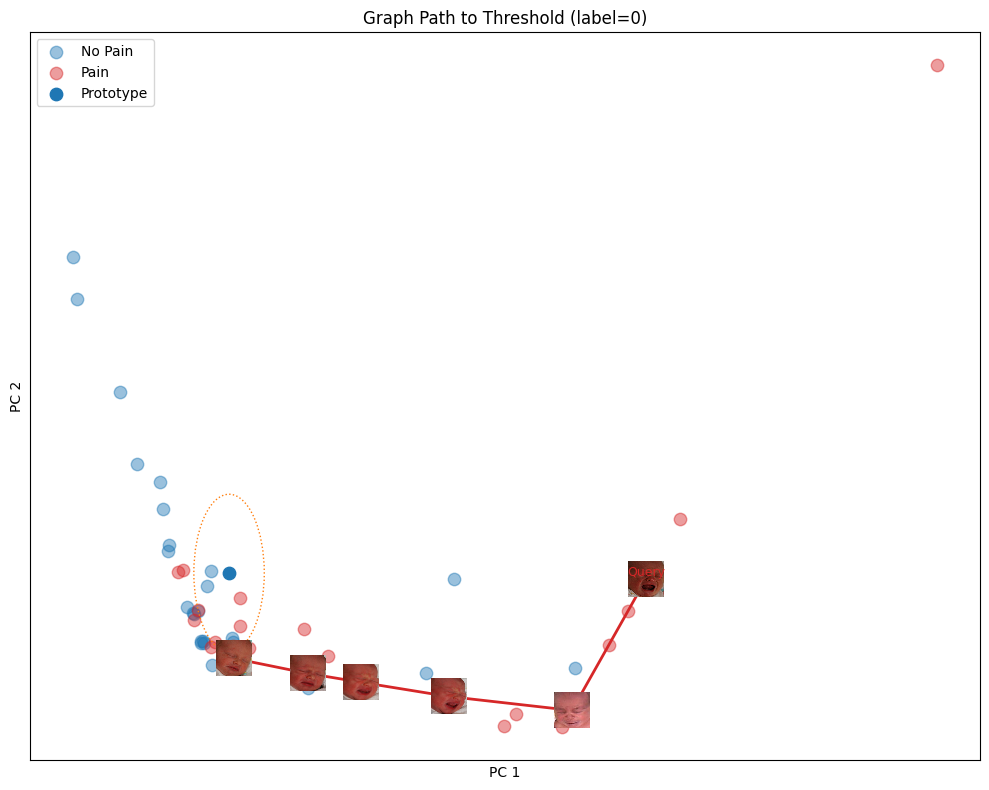

In [88]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.patches import Circle
from PIL import Image

# --- configure the scenario -------------------------------------------------
target_label = 0                  # target class
threshold = 0.8                    # L2 radius around the class prototype
k_graph = 8                        # neighbours per node in the k-NN graph
max_nodes = 1200                   # optional cap to keep the graph manageable
# ----------------------------------------------------------------------------

embeddings_aux = embeddings["embeddings"]
labels = embeddings["labels"]
paths = embeddings["paths"]

if isinstance(query_embedding, torch.Tensor):
    query_embedding = query_embedding.detach().cpu().numpy()
query_embedding = np.atleast_2d(query_embedding)[0]

# Optional subsampling (keeps the query neighbours accurate by prepending the query later)
if embeddings_aux.shape[0] > max_nodes:
    subset_idx = np.random.choice(embeddings_aux.shape[0], max_nodes, replace=False)
    embeddings_sub = embeddings_aux[subset_idx]
    labels_sub = labels[subset_idx]
    paths_sub = paths[subset_idx]
else:
    subset_idx = np.arange(embeddings_aux.shape[0])
    embeddings_sub = embeddings_aux
    labels_sub = labels
    paths_sub = paths

# Prototype of the target class
target_mask_global = labels == target_label
target_embeddings = embeddings_aux[target_mask_global]
if target_embeddings.size == 0:
    raise ValueError(f"No embeddings available for label {target_label}.")
prototype = target_embeddings.mean(axis=0)

# Nodes that already satisfy the threshold
target_mask_sub = labels_sub == target_label
target_nodes = np.where(
    target_mask_sub & (np.linalg.norm(embeddings_sub - prototype, axis=1) <= threshold)
)[0]
if target_nodes.size == 0:
    raise ValueError("No nodes within the threshold; adjust `threshold` or ensure coverage.")

# Build the undirected k-NN graph over the subset
nbrs = NearestNeighbors(n_neighbors=min(k_graph + 1, embeddings_sub.shape[0]), metric="euclidean")
nbrs.fit(embeddings_sub)
dist_matrix, idx_matrix = nbrs.kneighbors(embeddings_sub)

graph = [[] for _ in range(embeddings_sub.shape[0] + 1)]  # extra slot for the query node

for src in range(embeddings_sub.shape[0]):
    for dist, nbr_idx in zip(dist_matrix[src, 1:], idx_matrix[src, 1:]):  # skip self at position 0
        graph[src].append((nbr_idx, dist))
        graph[nbr_idx].append((src, dist))

# Connect the query as a new node at index N
query_index = embeddings_sub.shape[0]
q_dist, q_idx = nbrs.kneighbors(query_embedding.reshape(1, -1), n_neighbors=min(k_graph, embeddings_sub.shape[0]))
for dist, nbr_idx in zip(q_dist[0], q_idx[0]):
    graph[query_index].append((nbr_idx, dist))
    graph[nbr_idx].append((query_index, dist))

# Dijkstra search from the query node to the first target node
def dijkstra(adjacency, start, targets):
    targets = set(targets)
    dist = {start: 0.0}
    prev = {}
    heap = [(0.0, start)]
    while heap:
        cur_dist, node = heapq.heappop(heap)
        if node in targets:
            # Reconstruct the path
            path = [node]
            while path[-1] != start:
                path.append(prev[path[-1]])
            path.reverse()
            return cur_dist, path
        if cur_dist > dist[node]:
            continue
        for nbr, weight in adjacency[node]:
            new_dist = cur_dist + weight
            if nbr not in dist or new_dist < dist[nbr]:
                dist[nbr] = new_dist
                prev[nbr] = node
                heapq.heappush(heap, (new_dist, nbr))
    return None, []

total_len, path_nodes = dijkstra(graph, query_index, target_nodes)
if not path_nodes:
    raise RuntimeError("No path from the query to any threshold-satisfying node in this graph.")

print(f"Shortest path length (embedding L2 total): {total_len:.4f}")
print("Nodes traversed:", path_nodes)

# Extract embeddings/paths along the path (excluding the query index)
path_embeds = [query_embedding]
path_images = [query_path]
for node in path_nodes[1:]:
    path_embeds.append(embeddings_sub[node])
    path_images.append(paths_sub[node])
path_embeds = np.array(path_embeds)

# PCA projection for visualization (query + subset)
pca_data = np.vstack([embeddings_sub, query_embedding])
coords = PCA(n_components=2, random_state=0).fit_transform(pca_data)
coord_subset = coords[:-1]
coord_query = coords[-1]

def add_thumbnail(ax, xy, img_path, zoom=0.1, highlight=False, color="red"):
    img = Image.open(img_path)
    ab = AnnotationBbox(OffsetImage(img, zoom=zoom), xy, frameon=False)
    ax.add_artist(ab)
    if highlight:
        ax.scatter(*xy, s=4000 * zoom, facecolors="none", edgecolors=color, linewidths=2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title(f"Graph Path to Threshold (label={target_label})")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

#ax.scatter(coord_subset[:, 0], coord_subset[:, 1], s=80, color="#cccccc", alpha=0.5)

# Map labels to display names / colors
label_names = {0: "No Pain", 1: "Pain"}
label_colors = {0: "tab:blue", 1: "tab:red"}

for value in np.unique(labels_sub):
    mask = labels_sub == value
    ax.scatter(
        coord_subset[mask, 0],
        coord_subset[mask, 1],
        s=80,
        color=label_colors.get(value, "gray"),
        alpha=0.45,
        label=label_names.get(value, f"Label {value}"),
    )


# Draw prototype and threshold circle (in PCA space for illustration only)
proto_proj = PCA(n_components=2, random_state=0).fit_transform(np.vstack([embeddings_aux, prototype]))[-1]
proto_circle_radius = np.linalg.norm(coord_subset[target_nodes[0]] - proto_proj[:2])
circle = Circle(proto_proj[:2], proto_circle_radius, fill=False, color="tab:orange", linestyle=":")
ax.add_patch(circle)
ax.scatter(*proto_proj[:2], color="tab:blue", s=80, label="Prototype")

# Plot the path edges
path_coords = [coord_query] + [coord_subset[node] for node in path_nodes[1:]]
for (x0, y0), (x1, y1) in zip(path_coords[:-1], path_coords[1:]):
    ax.plot([x0, x1], [y0, y1], color="tab:red", linewidth=2)

# Place thumbnails along the path
add_thumbnail(ax, coord_query, query_path, zoom=0.05, highlight=True)
for node, xy, img_path in zip(path_nodes[1:], path_coords[1:], path_images[1:]):
    add_thumbnail(ax, xy, img_path, zoom=0.05)

ax.text(coord_query[0], coord_query[1], "Query", fontsize=9, ha="center", va="bottom", color="tab:red")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.legend()
plt.show()
